# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file
style.use('default')

In [2]:
plt.rcParams['backend'] = 'SVG'

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [3]:
df = pd.read_excel('../data/HIST_PAINEL_COVIDBR_11jul2020.xlsx')
# tratamento inicial dos valores de população
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

### Dias de semana como varíável categórica 

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [5]:
uf = 'DF'
Muni = 'Brasília'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def preproc_filter_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [7]:
df_est, df_est_sem, df_cidade, df_cidade_sem = preproc_filter_df(df, uf, Muni)

In [8]:

def casos_acumulados(df_muni, muni, pathfigs = './figs/'):
    df_muni.sort_values('data', inplace = True)
    df_muni['ca_log'] = df_muni['casosAcumulado'].apply(lambda x: np.log10(x))
    dia_0 = df_muni['data'].min()
    df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{}: \n Casos Acumulados por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'casosAcumulado', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
##### figura 01 -casos acumulados por dia(log)
    plt.figure(2, figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados por Dia(log)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'ca_log', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_log10_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(2)
    print ('dia zero', dia_0)
    print('Casos Novos\n',df_muni.loc[:,['casosNovos', 'data']].tail(14))
    print('Casos Totais\n', df_muni['casosAcumulado'].max())
    

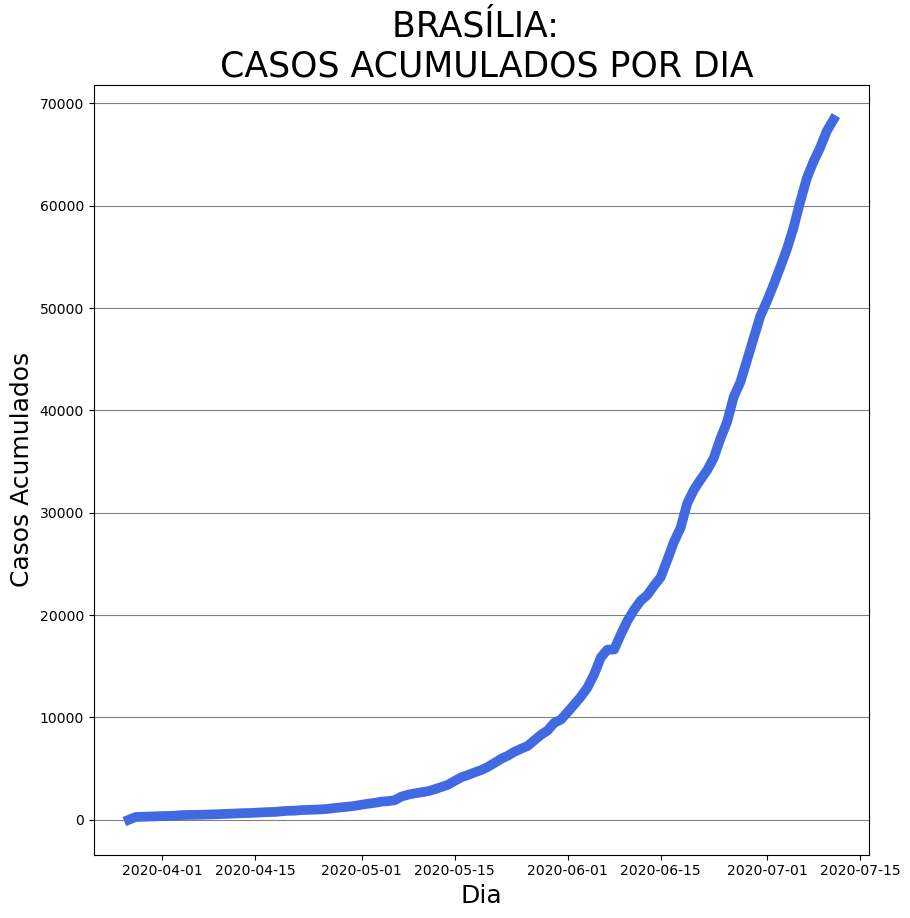

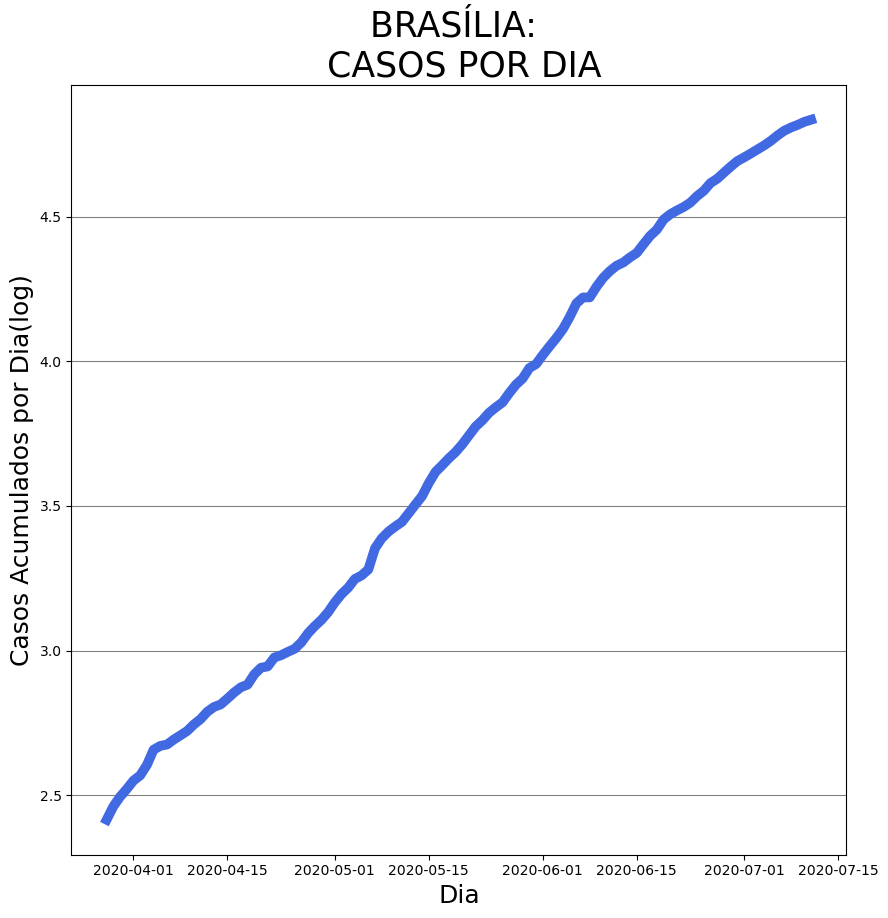

dia zero 2020-03-27 00:00:00
Casos Novos
         casosNovos       data
586786        2139 2020-06-28
586787        2166 2020-06-29
586788        2147 2020-06-30
586789        1458 2020-07-01
586790        1605 2020-07-02
586791        1715 2020-07-03
586792        1764 2020-07-04
586793        2094 2020-07-05
586794        2529 2020-07-06
586795        2311 2020-07-07
586796        1620 2020-07-08
586797        1363 2020-07-09
586798        1620 2020-07-10
586799        1109 2020-07-11
Casos Totais
 68406


In [9]:
casos_acumulados(df_cidade, Muni)

### Função Grafico de casos por dia

In [10]:
def casos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    print('Casos Totais\n', df1['casosAcumulado'].max())

    fig = plt.figure(1, figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='casosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    
    plt.title('{}: \n Casos por Semana Epidemiológica por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=20)
    plt.ylabel('Número de Casos', fontsize=20)
    plt.grid(axis='y', color='grey')
    plt.rcParams['legend.title_fontsize'] = 18

    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_casos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)

Casos Totais
 68406


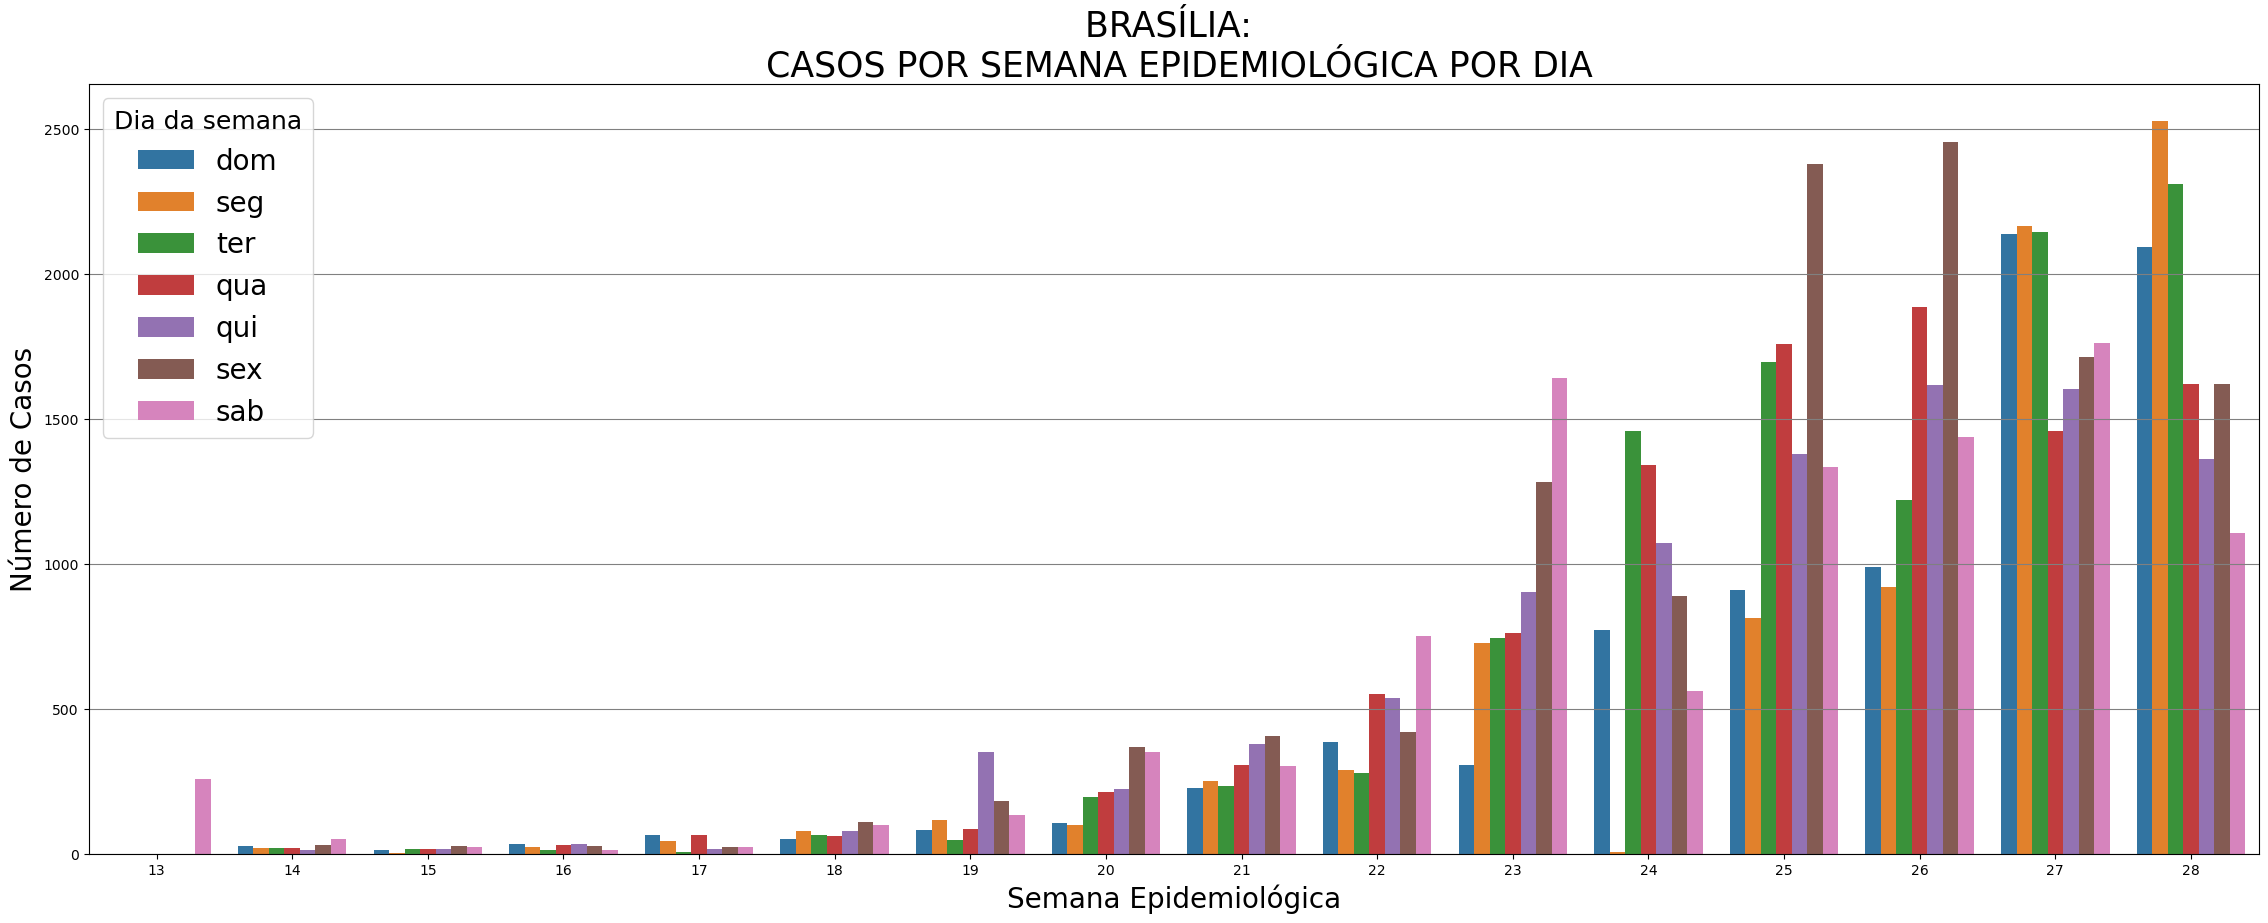

In [11]:
casos_dia_local(df_cidade, Muni)

### Casos por dia (média móvel de 5 dias centralizada)

In [12]:
def casos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ###- tratando números negativos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])

    df1['media_movel_casos'] =df1.rolling(5, center=True)['casosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia (média móvel de 5 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos (média móvel de 5 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_casos', data=df1, color= 'teal', width=.8)
    plt.savefig( pathfigs + local + '_dia_casos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_casos', 'data']].head(14))
    print(df1.loc[:,['media_movel_casos', 'data']].tail(14))

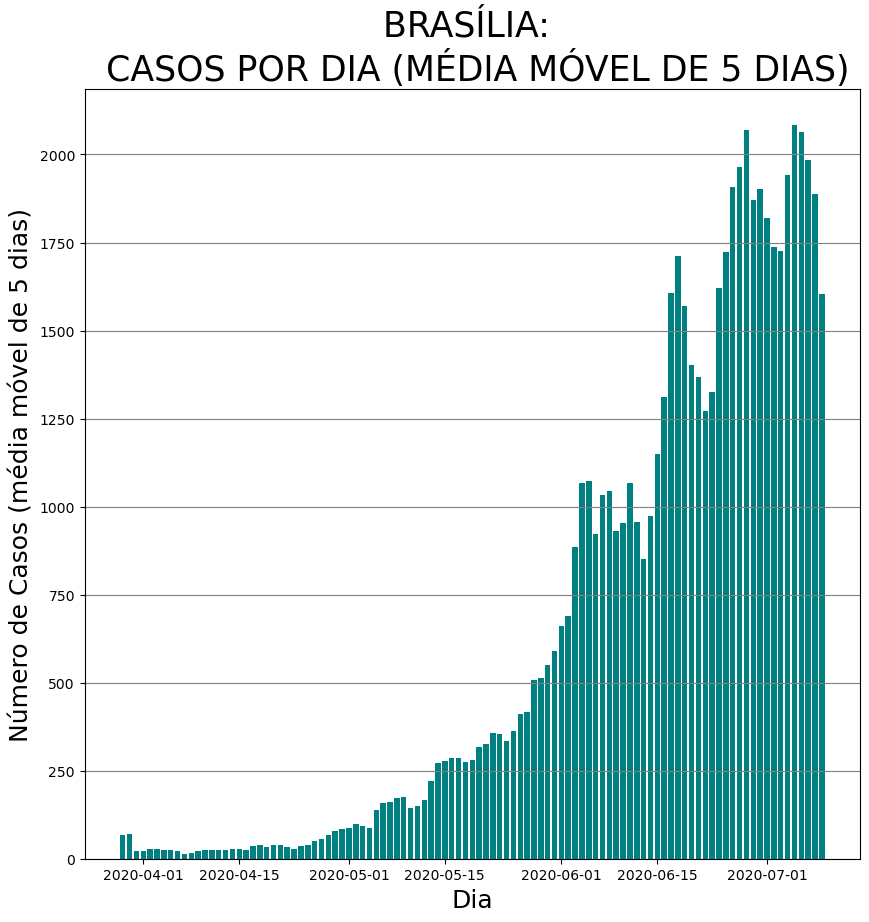

Média móvel por dia
         media_movel_casos       data
586693                NaN 2020-03-27
586694                NaN 2020-03-28
586695               66.4 2020-03-29
586696               71.0 2020-03-30
586697               22.0 2020-03-31
586698               22.6 2020-04-01
586699               28.4 2020-04-02
586700               27.2 2020-04-03
586701               23.6 2020-04-04
586702               24.4 2020-04-05
586703               21.4 2020-04-06
586704               14.6 2020-04-07
586705               17.4 2020-04-08
586706               21.2 2020-04-09
        media_movel_casos       data
586786             2069.4 2020-06-28
586787             1870.0 2020-06-29
586788             1903.0 2020-06-30
586789             1818.2 2020-07-01
586790             1737.8 2020-07-02
586791             1727.2 2020-07-03
586792             1941.4 2020-07-04
586793             2082.6 2020-07-05
586794             2063.6 2020-07-06
586795             1983.4 2020-07-07
586796           

In [13]:
casos_dia_media_movel(df_cidade, Muni)

In [14]:
def obitos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ### valores negativos de novos obitos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    
    print('Óbitos por dia\n',df1.loc[:,['obitosNovos', 'data']].tail(14))
    print('Óbitos Totais\n', df1['obitosAcumulado'].max())

    fig =  plt.figure(1,figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='obitosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    plt.title('{}: \n Óbitos por Semana Epidemiológica por dia da semana'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_obitos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
    


Óbitos por dia
         obitosNovos       data
586786           11 2020-06-28
586787           11 2020-06-29
586788           28 2020-06-30
586789           33 2020-07-01
586790           11 2020-07-02
586791           12 2020-07-03
586792           28 2020-07-04
586793           28 2020-07-05
586794           27 2020-07-06
586795           41 2020-07-07
586796           34 2020-07-08
586797           22 2020-07-09
586798           33 2020-07-10
586799           15 2020-07-11
Óbitos Totais
 871


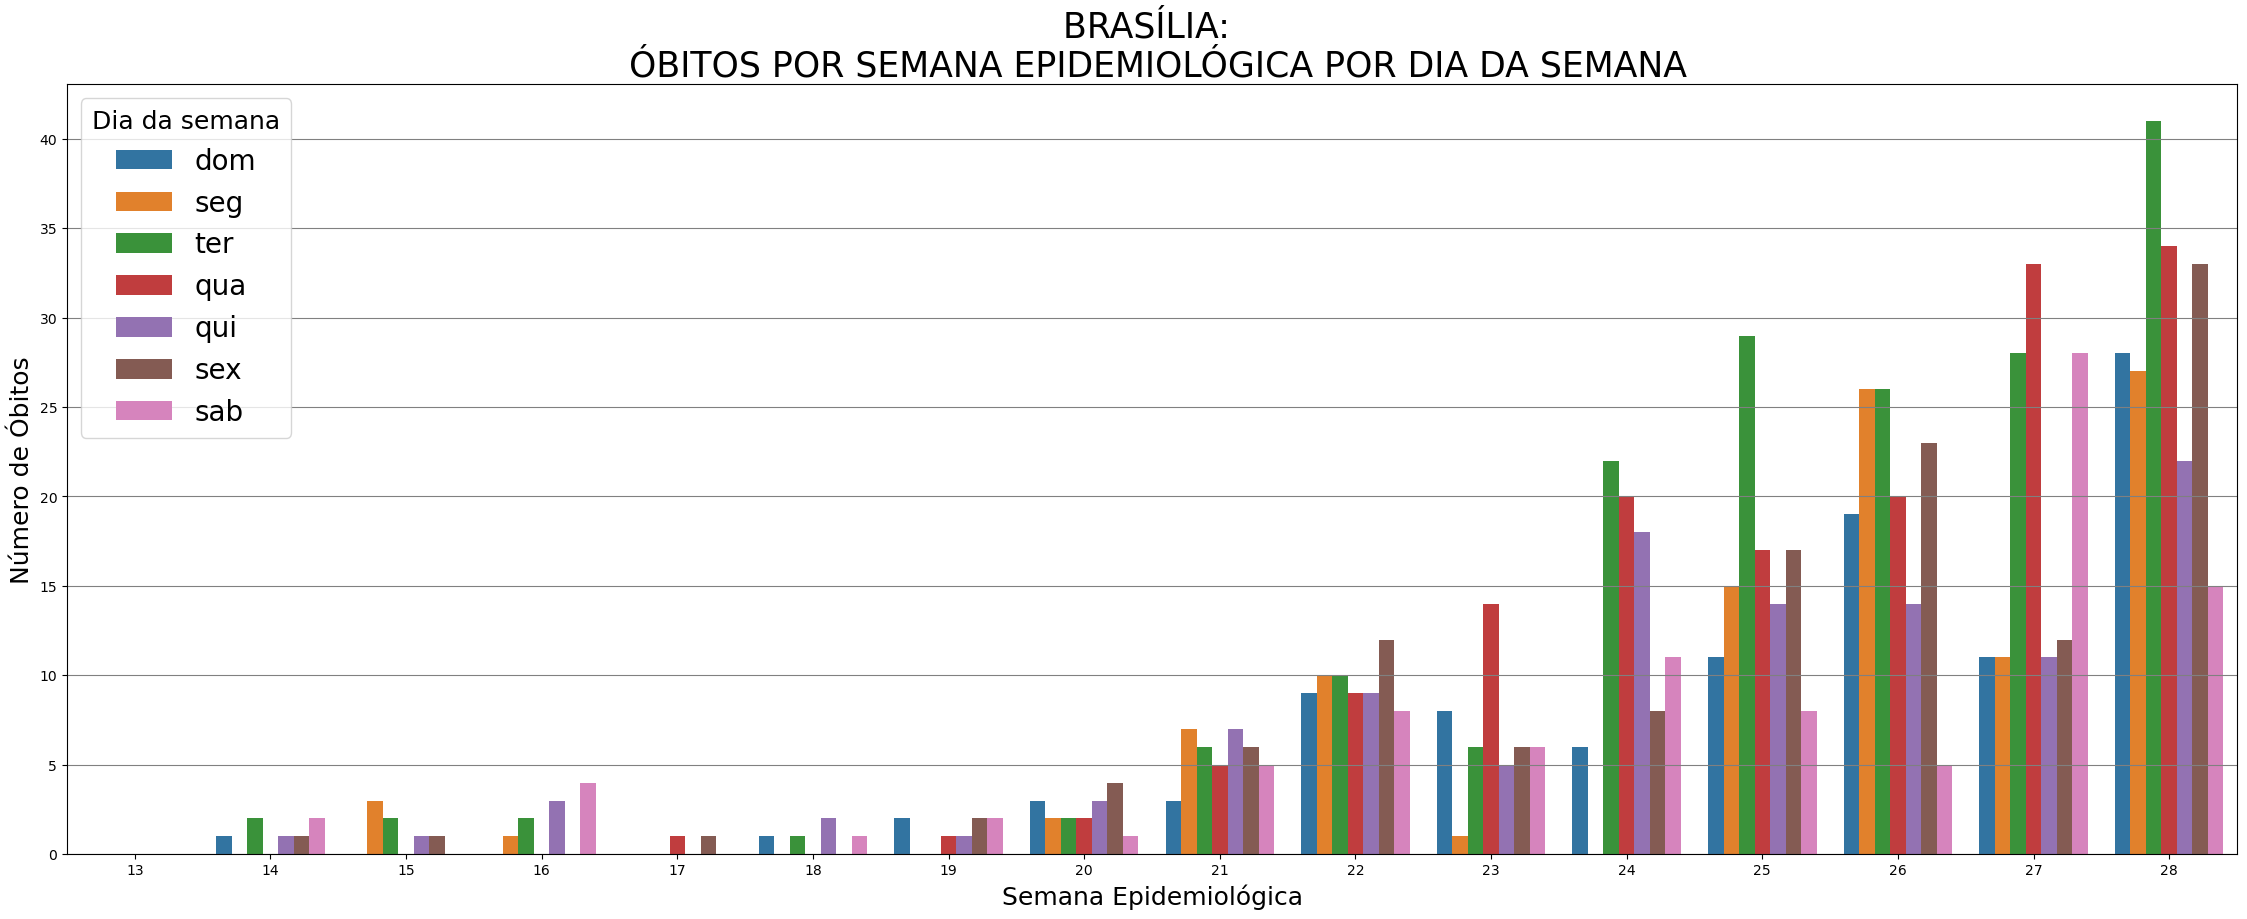

In [15]:
obitos_dia_local(df_cidade, Muni)

### Obitos por dia (média movel de 5 dias centralizada)

In [16]:
def obitos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    df1['media_movel_obitos'] =df1.rolling(5, center=True)['obitosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia (média móvel de 5 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos (média móvel de 5 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_obitos', data=df1, color= 'saddlebrown', width=.8)
    plt.savefig( pathfigs + local + '_dia_obitos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_obitos', 'data']].head(14))
    print(df1.loc[:,['media_movel_obitos', 'data']].tail(14))

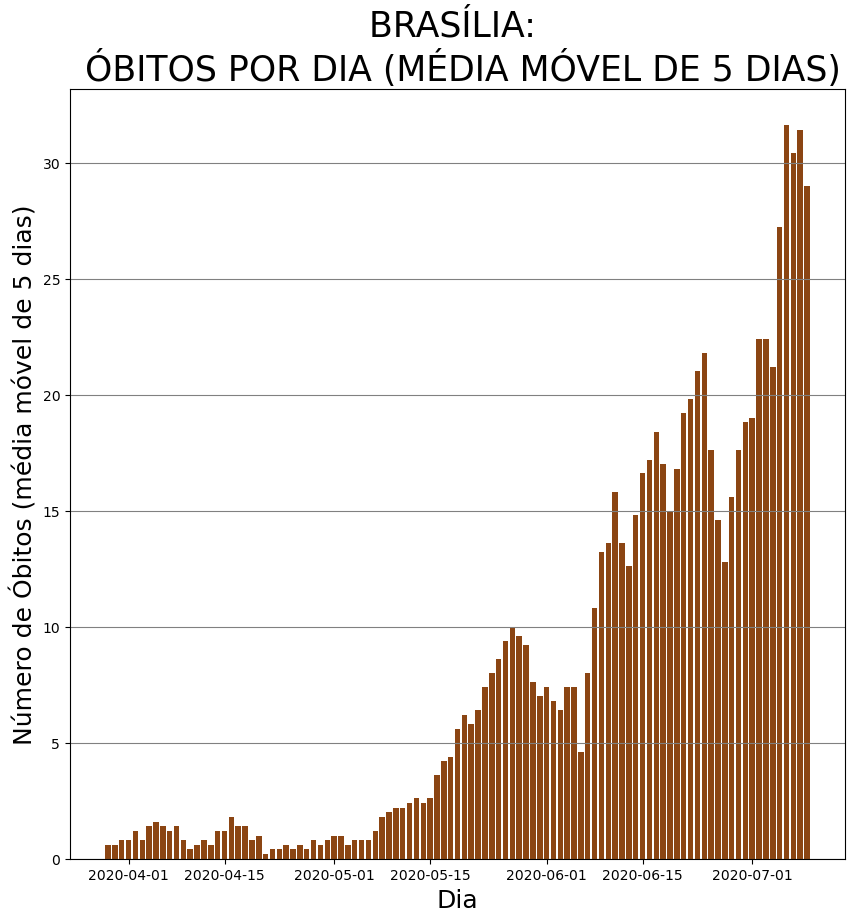

Média móvel por dia
         media_movel_obitos       data
586693                 NaN 2020-03-27
586694                 NaN 2020-03-28
586695                 0.6 2020-03-29
586696                 0.6 2020-03-30
586697                 0.8 2020-03-31
586698                 0.8 2020-04-01
586699                 1.2 2020-04-02
586700                 0.8 2020-04-03
586701                 1.4 2020-04-04
586702                 1.6 2020-04-05
586703                 1.4 2020-04-06
586704                 1.2 2020-04-07
586705                 1.4 2020-04-08
586706                 0.8 2020-04-09
        media_movel_obitos       data
586786                15.6 2020-06-28
586787                17.6 2020-06-29
586788                18.8 2020-06-30
586789                19.0 2020-07-01
586790                22.4 2020-07-02
586791                22.4 2020-07-03
586792                21.2 2020-07-04
586793                27.2 2020-07-05
586794                31.6 2020-07-06
586795                30.4 20

In [17]:
obitos_dia_media_movel(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [18]:
def casos_semana_local(df, local, pathfigs = './figs/'):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( pathfigs + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print('Casos por semana epidemiológica\n',df.loc[:,['semanaEpi','casosNovos']])

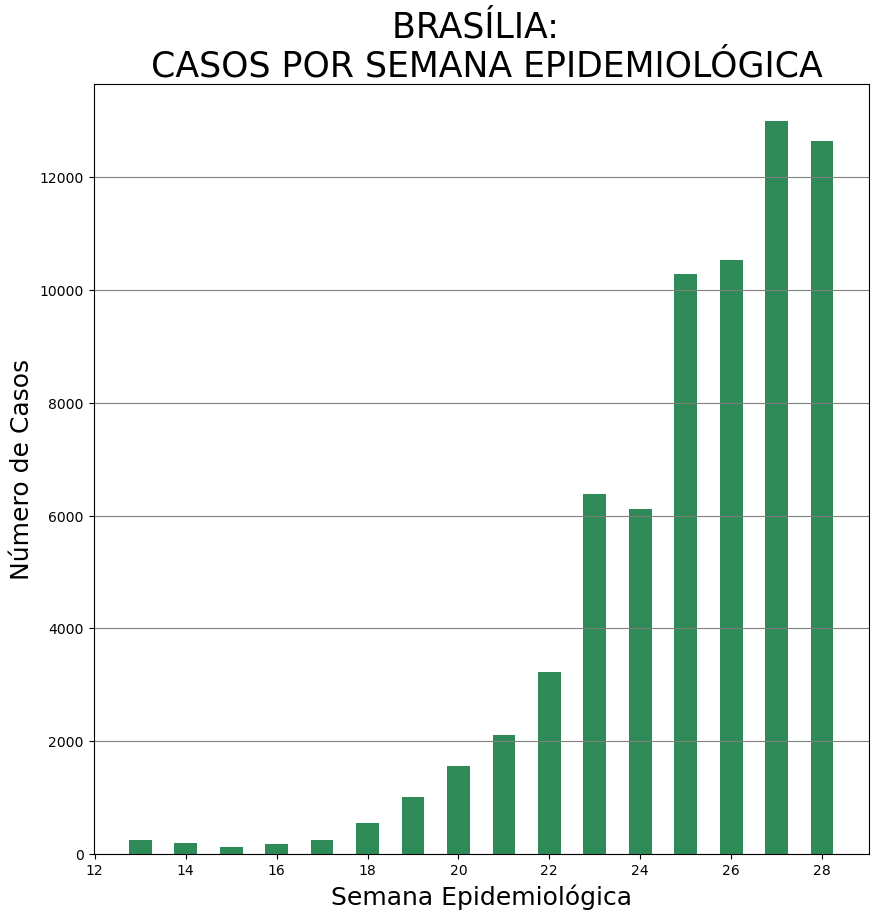

Casos por semana epidemiológica
     semanaEpi  casosNovos
0          13         260
1          14         194
2          15         125
3          16         183
4          17         251
5          18         553
6          19        1010
7          20        1564
8          21        2111
9          22        3223
10         23        6376
11         24        6109
12         25       10279
13         26       10528
14         27       12994
15         28       12646


In [19]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [20]:
def obitos_semana_local(df, local, pathfigs = './figs/'):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( pathfigs + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')


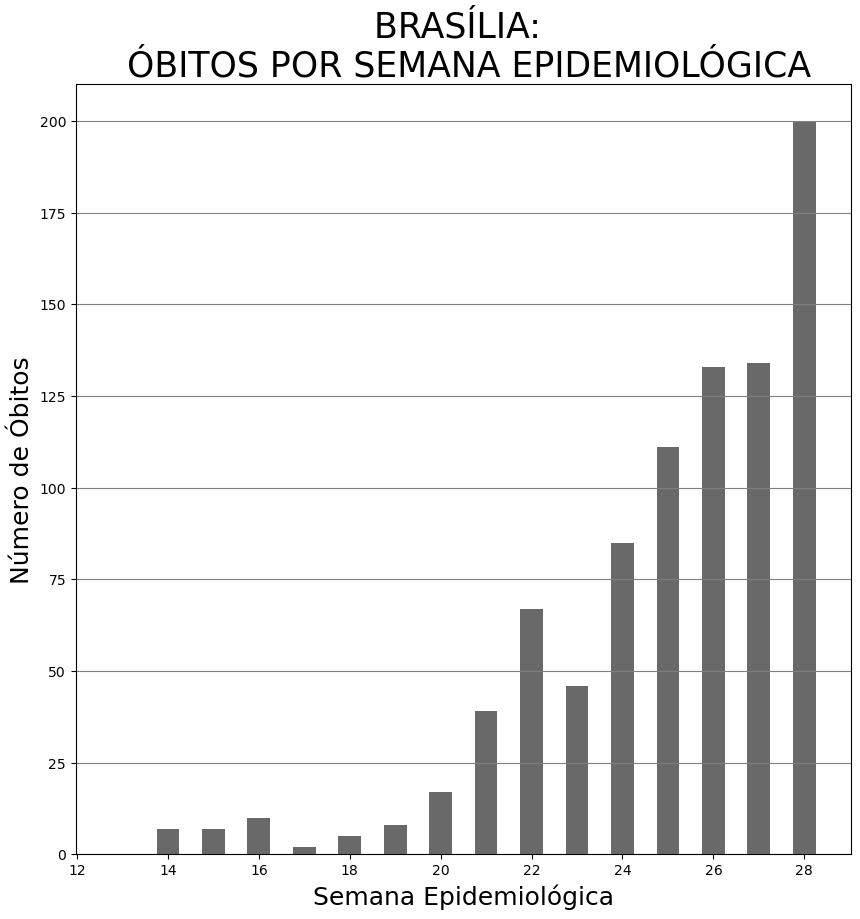

In [21]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [22]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\GitRepos\graficos_covid\acompanhamento_df


'd:\\GitRepos\\graficos_covid\\acompanhamento_df\\geojsonDL\\DF.json'

### Carregando arquivo GeoJson do estado

In [23]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [24]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid-19 -- {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

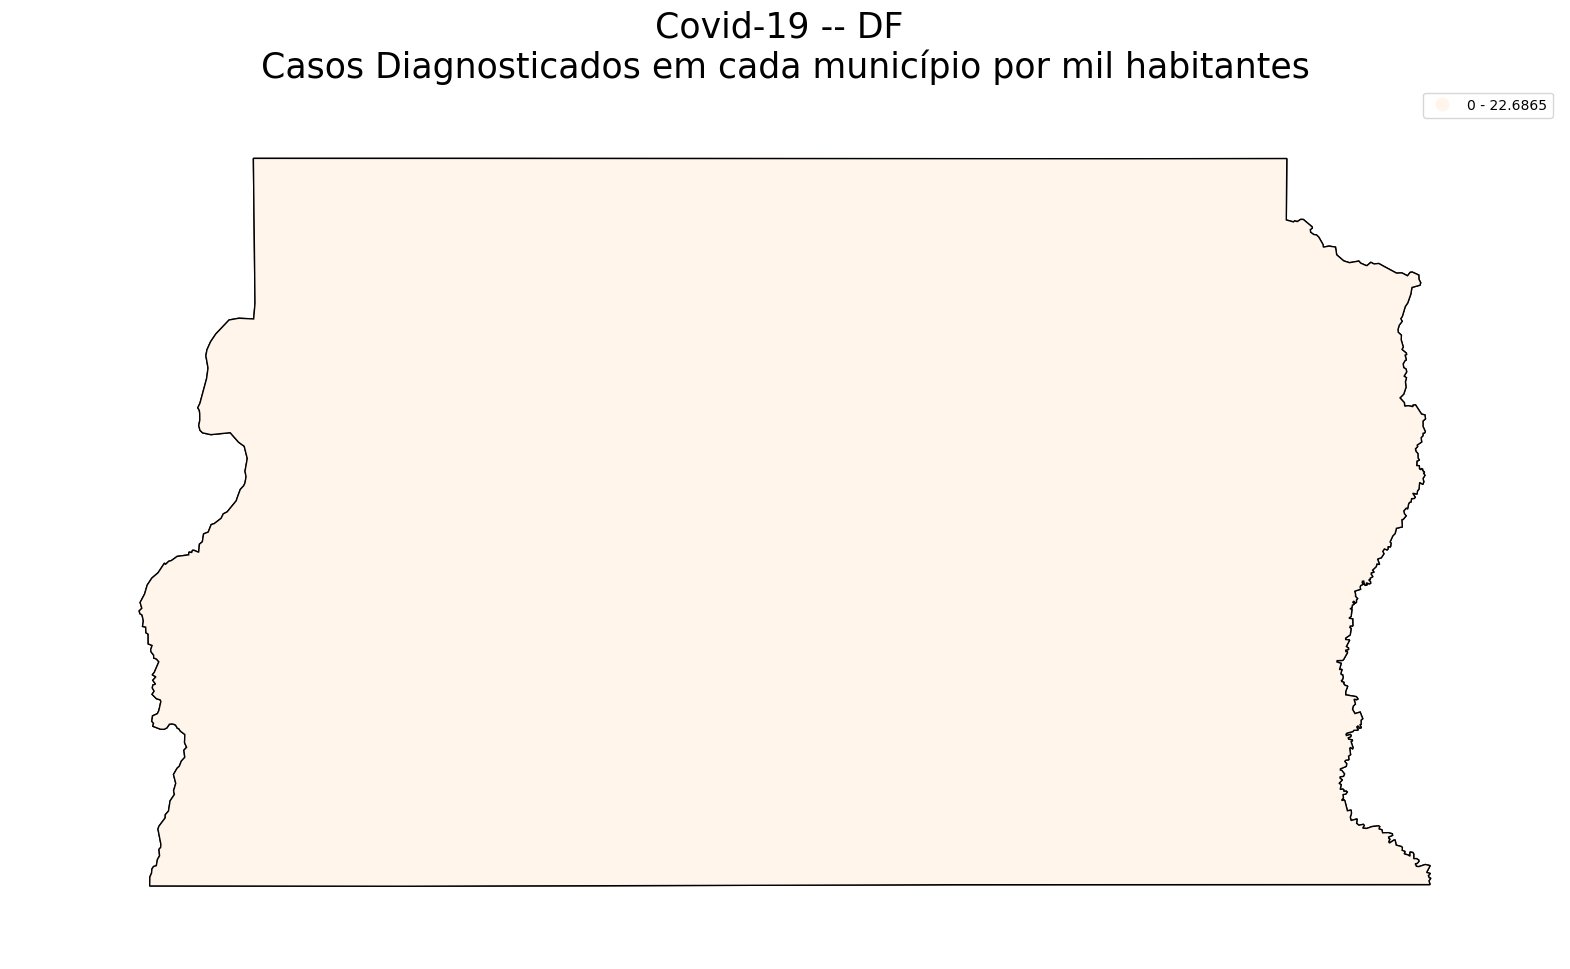

In [25]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

In [26]:
def mapa_obitos_estado(df, df_geo, uf, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid-19 -- {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


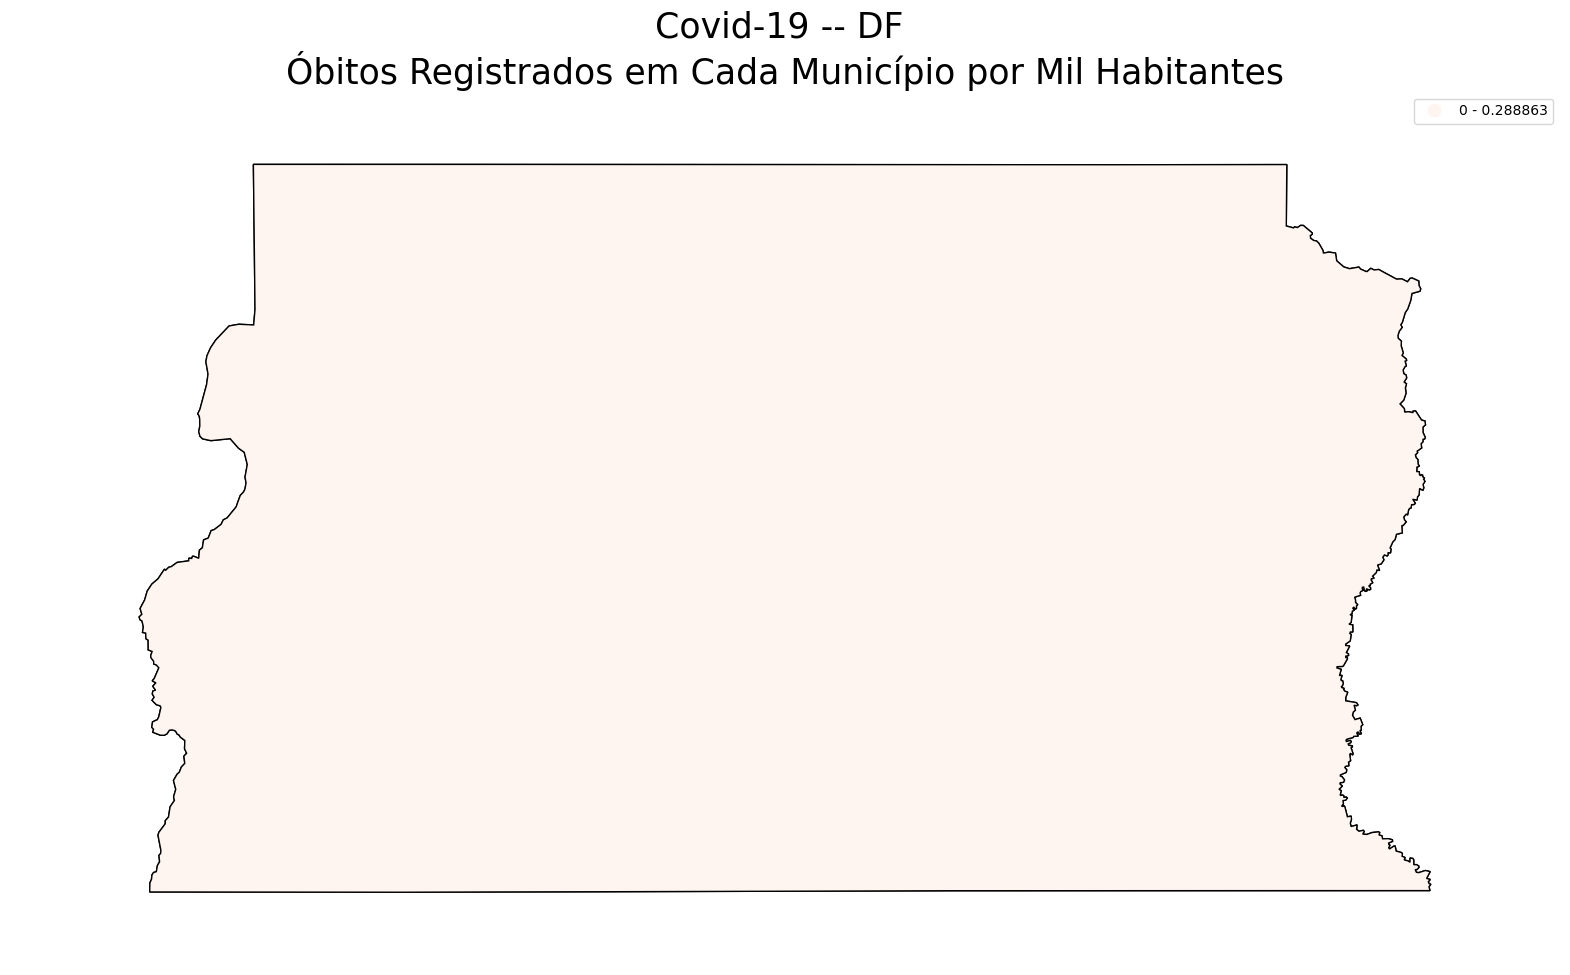

In [27]:
mapa_obitos_estado(df_est, mapa, uf, 20)